In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
import numpy as np
import pandas as pd
import cv2
from skimage.util import montage 

%matplotlib inline
tf.__version__

import sys
print(sys.version)
print(sys.executable)

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
C:\ProgramData\Anaconda3\python.exe


In [4]:
import math
from PIL import Image, ImageDraw, ImageColor
import json
import glob
import os
import cv2
import nibabel as nib

In [5]:
#draw images
from datetime import datetime
def drawCategorizedImages(folderPath, dict, fontsize=10, fontfamily='MingLiU'):
    for patient in dict:
        for study in dict[patient]:
            for series in dict[patient][study]:
                fileList = dict[patient][study][series]
                imagesList = []
                for file in fileList:
                    imagesList.append(dcmread(folderPath + file))
                imagesList.sort(key=lambda x: x.InstanceNumber, reverse=False) # sort image by instance number
                quantity = len(imagesList)
                cols = 10
                rows = math.ceil(quantity/cols)
                rows = rows + int(rows/6) + 1 # add blank rows to place text
                fig = plt.figure(figsize=(cols*2,rows*2))
                flag = True
                for i in range(quantity):
                    ds = imagesList[i]

                    if ("PixelData" in ds):
                        #add text only once
                        if flag:
                            plt.text(0.01,0.135,"PatientName: " + str(ds.PatientName), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.01,0.11,"PatientID: " + str(ds.PatientID), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.01,0.085,"Sex: " + str(ds.PatientSex), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.135,"InstitutionName: " + ds.InstitutionName if ds.InstitutionName != "" else "InstitutionName: None", fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.11,"StudyDescription: " + ds.StudyDescription, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.085,"StudyID: " + ds.StudyID, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.06,"AccessionNumber: " + ds.AccessionNumber, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.035,"AcquisitionDate: " + str(datetime.strptime(ds.AcquisitionDate, '%Y%m%d').date()), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.01,"AcquisitionTime: " + ds.AcquisitionTime, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.66,0.135,"SeriesNumber: " + str(ds.SeriesNumber), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.66,0.11,"SeriesDescription: " + str(ds.SeriesDescription), fontsize=fontsize, fontfamily=fontfamily)
#                             plt.text(0.66,0.085,"SliceThickness: " + str(math.ceil(ds.SliceThickness)) + "mm", fontsize=fontsize, fontfamily=fontfamily)
#                             plt.text(0.66,0.06,"SliceLocation: " + str(math.ceil(ds.SliceLocation)) + "mm", fontsize=fontsize, fontfamily=fontfamily)
                            flag = False   

                        fig.add_subplot(rows, cols, i+1)
                        plt.imshow(ds.pixel_array, cmap='gray')
                        plt.axis('off')

In [6]:
def showImagesWithPyPlot(images):
    quantity = len(images)
    cols = 6
    rows = math.ceil(quantity/cols)
    fig,ax = plt.subplots(rows,cols,figsize=(20,3*rows))
    for i in range(quantity):
        ax[i//cols][i%cols].imshow(images[i])

In [ ]:
#superimpose original image and label
path = "20221005/003/003-MR/"
images_path = glob.glob(path + '*_0.png')
labels_path = glob.glob(path + '*_anno.png')
images = []
for i in range(len(images_path)):
    image = Image.open(images_path[i])
    label = Image.open(labels_path[i])
    image.paste(label,(0,0),mask=label)
    images.append(image)
    
#show superimposed images with pyplot
showImagesWithPyPlot(images)

In [ ]:
#draw lines with pillow and add images to list
path = "20221005/003/003-MR/"
images_path = glob.glob(path + '*_0.png')
labels_path = glob.glob(path + '*_anno.png')
jsonFiles = glob.glob(path + "*.json")
images = []
strokeColor = ""
for i in jsonFiles:    
    file = open(i)
    data = json.load(file)
    im = Image.new("RGB", data['size'])
    draw = ImageDraw.Draw(im)
    shapes = data['shapes']
    for shape in shapes:
        segments = shape['segments']
        strokeColor = shape['strokeColor']
        for segment in segments:
            startEndCoord = [(segment['a'][0], segment['a'][1]),(segment['b'][0], segment['b'][1])]
            draw.line(startEndCoord, fill=strokeColor)
    images.append(im)


#fill contour
filledLabelImages = []
counter = 1
if(not os.path.exists('label')):
    os.mkdir('label')
for image in images:
    grayImage  = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2GRAY)
    cnts = cv2.findContours(grayImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(grayImage,[c], 0, (255,255,255), -1)

    colorImage = cv2.cvtColor(grayImage,cv2.COLOR_GRAY2RGB)
    colorImage[np.all(colorImage == (255, 255, 255), axis=-1)] = ImageColor.getcolor(strokeColor, "RGB")    
    
    #convert black background to transparent
    _, alpha = cv2.threshold(grayImage, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(colorImage)
    rgba = [b, g, r, alpha]
    colorImage = cv2.merge(rgba, 4)
    
    #convert cv2 to pil format
    pilImage = Image.fromarray(colorImage)
    pilImage.save('label/img' + str(counter) + '.png')
    filledLabelImages.append(pilImage)    
    counter+=1
    
    
#show filledLabels with pyplot
print("Quantity: " + str(len(filledLabelImages)))
showImagesWithPyPlot(filledLabelImages)
    
#superimpose filledLabelImages to original mri images and show
images=[]
for i in range(len(filledLabelImages)):
    image = Image.open(images_path[i])
    labelImage = filledLabelImages[i]
#     alpha = Image.new("L", labelImage.size, 100)
#     labelImage.putalpha(alpha)
    image.paste(labelImage,(0,0),mask=labelImage)
    images.append(image)
showImagesWithPyPlot(images)

In [6]:
#find images file name by SeriesNumber to be drawn
from pydicom.fileset import FileSet
dicomdir = dcmread("002/dicomdir")
fs = FileSet(dicomdir)
# print(fs)

In [7]:
#categorize dicom files with patientID, studyID and seriesID using dicomdir
dict = {}
patientIDs = fs.find_values("PatientID")
for patientID in patientIDs:
    instances = fs.find(PatientID=patientID)
    for ds in instances:
        patientID = ds.PatientID
        studyID = ds.StudyID
        seriesID = ds.SeriesNumber
        fileName = ds.ReferencedFileID
        if patientID in dict:
            if studyID in dict[patientID]:
                if seriesID in dict[patientID][studyID]:
                    dict[patientID][studyID][seriesID].append(fileName)
                else:
                    dict[patientID][studyID][seriesID] = [fileName]
            else:
                dict[patientID][studyID] = {seriesID:[fileName]}
        else:
            dict[patientID] = {studyID:{seriesID:[fileName]}}

In [ ]:
#draw images
drawCategorizedImages('002/', dict, fontsize=15, fontfamily='DejaVu Sans')

In [47]:
#categorize dicom files with patientID, studyID and seriesID without using dicomdir
path = "20221005/003/003-MR/"
files = glob.glob(path + "*.dcm")
dict = {}
for file in files:
    ds = dcmread(file)
    patientID = ds.PatientID
    studyID = ds.StudyID
    seriesID = ds.SeriesNumber
    if patientID in dict:
        if studyID in dict[patientID]:
            if seriesID in dict[patientID][studyID]:
                dict[patientID][studyID][seriesID].append(file)
            else:
                dict[patientID][studyID][seriesID] = [file]
        else:
            dict[patientID][studyID] = {seriesID:[file]}
    else:
        dict[patientID] = {studyID:{seriesID:[file]}}

In [ ]:
#draw images
drawCategorizedImages('', dict, fontsize=13)

In [48]:
patientID = list(dict)[0]
print(patientID)

2546286


In [49]:
#Prepare dataset for input->(128,128,48,3)
SIZE = 128
DEPTH = 48
CHANNEL = 3
patientID = list(dict)[0]
t1 = dict[patientID]['1'][901]
t2 = dict[patientID]['1'][501]
flair = dict[patientID]['1'][701]

t1_ds = [dcmread(i) for i in t1]
t1_ds.sort(key=lambda x: x.InstanceNumber, reverse=False)
t2_ds = [dcmread(i) for i in t2]
t2_ds.sort(key=lambda x: x.InstanceNumber, reverse=False)
flair_ds = [dcmread(i) for i in flair]
flair_ds.sort(key=lambda x: x.InstanceNumber, reverse=False)

t1s = np.zeros((SIZE,SIZE,DEPTH))
t2s = np.zeros((SIZE,SIZE,DEPTH))
flairs = np.zeros((SIZE,SIZE,DEPTH))

for c, i in enumerate(t1_ds):
    t1s[:,:,c] = cv2.resize(i.pixel_array, (128,128))
for c, i in enumerate(t2_ds):
    t2s[:,:,c] = cv2.resize(i.pixel_array, (128,128))
for c, i in enumerate(flair_ds):
    flairs[:,:,c] = cv2.resize(i.pixel_array, (128,128))

In [50]:
#save combined channels to npy files
data_3channels = np.stack([flairs,t1s,t2s], axis=3)
print(data_3channels.shape)
if(not os.path.exists('input_data_3channels')):
    os.makedirs('input_data_3channels')
np.save('input_data_3channels/'+path.split('/')[1]+'.npy', data_3channels)

(128, 128, 48, 3)


In [ ]:
def save_nii_to_png(niifile):    
    img = nib.load(niifile)
    fdata = img.get_fdata()
    (x,y,z) = fdata.shape
    for i in range(z):
        slice_pic = fdata[:,:,i]
        plt.imsave('nii_to_png/img' + str(i+1) + '.png', slice_pic, cmap='gray')

TRAIN_DATASET_PATH = ''
test_image = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001_seg.nii')
print(test_image)
test_image = test_image.get_fdata()
plt.figure(figsize=(20,20))

for i in range(test_image.shape[2]):
    plt.subplot(11,15,i+1)
    plt.imshow(test_image[:,:,i])
    plt.axis('off')

if(not os.path.exists('nii_to_png')):
    os.mkdir('nii_to_png')
save_nii_to_png(TRAIN_DATASET_PATH + 'BraTS20_Training_001_seg.nii')

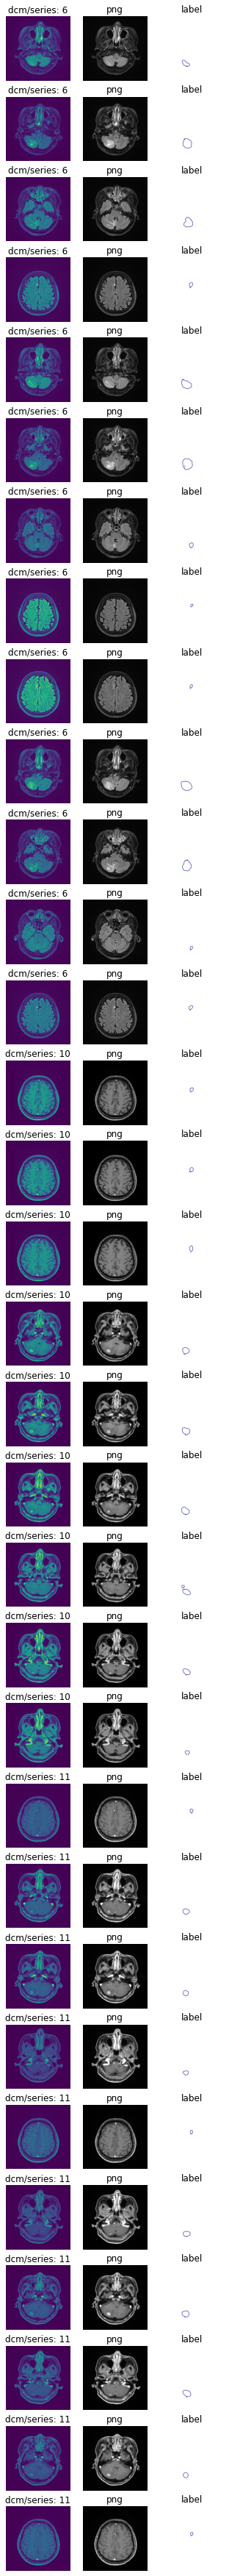

In [114]:
### 嘗試用標記檔配對dcm檔
path = "20221005/002/002-MR"
files = glob.glob(path + "/*.dcm")
pngs = glob.glob(path + "/*0.png")
labes = glob.glob(path + "/*anno.png")
cols = 3
rows = len(pngs)
fig = plt.figure(figsize=(rows/6,rows*2))
for i in range(len(pngs)):
    sopID = str(pngs[i].split(path)[1][1:-6]) #去除資料夾字段及後綴，保留UID
    for j in files:
        f = dcmread(j)
        if(str(f.SOPInstanceUID) == sopID):
            ax1 = fig.add_subplot(rows,cols,(i*cols)+1)
            ax1.title.set_text('dcm/series: ' + str(f.SeriesNumber))
            plt.imshow(f.pixel_array)
            plt.axis('off')
            ax2 = fig.add_subplot(rows,cols,(i*cols)+2)
            ax2.title.set_text('png')
            plt.imshow(Image.open(pngs[i]))
            plt.axis('off')
            ax3 = fig.add_subplot(rows,cols,(i*cols)+3)
            ax3.title.set_text('label')
            plt.imshow(Image.open(labes[i]))
            plt.axis('off')

In [100]:
# interpolating between two images

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import interpolate
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage.interpolation import shift

def inter(images,t):
    # input: 
    # images: list of arrays/frames ordered according to motion
    # t: parameter ranging from 0 to 1 corresponding to first and last frame 
    # returns: interpolated image

    #direction of movement, assumed to be approx. linear 
    a=np.array(center_of_mass(images[0]))
    b=np.array(center_of_mass(images[-1]))

    #find index of two nearest frames
    arr=np.array([center_of_mass(images[i]) for i in range(len(images))])
    v=a+t*(b-a) #convert t into vector 
    idx1 = (np.linalg.norm((arr - v),axis=1)).argmin()
    arr[idx1]=np.array([0,0]) #this is sloppy, should be changed if relevant values are near [0,0]
    idx2 = (np.linalg.norm((arr - v),axis=1)).argmin()

    if idx1>idx2:
        b=np.array(center_of_mass(images[idx1])) #center of mass of nearest contour
        a=np.array(center_of_mass(images[idx2])) #center of mass of second nearest contour
        tstar=np.linalg.norm(v-a)/np.linalg.norm(b-a) #define parameter ranging from 0 to 1 for interpolation between two nearest frames
        im1_shift=shift(images[idx2],(b-a)*tstar) #shift frame 1
        im2_shift=shift(images[idx1],-(b-a)*(1-tstar)) #shift frame 2
        return im1_shift+im2_shift #return average

    if idx1<idx2:
        b=np.array(center_of_mass(images[idx2]))
        a=np.array(center_of_mass(images[idx1]))
        tstar=np.linalg.norm(v-a)/np.linalg.norm(b-a)
        im1_shift=shift(images[idx2],-(b-a)*(1-tstar))
        im2_shift=shift(images[idx1],(b-a)*(tstar))
        return im1_shift+im2_shift


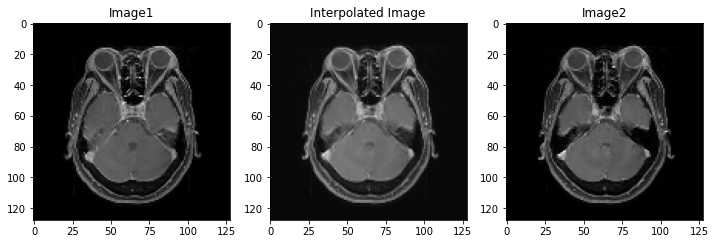

In [129]:
imageList = [t1s[:,:,33],t1s[:,:,34]]
out = inter(imageList, 0)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image1')
plt.imshow(imageList[0],cmap='gray')
plt.subplot(232)
plt.title('Interpolated Image')
plt.imshow(out,cmap='gray')
plt.subplot(233)
plt.title('Image2')
plt.imshow(imageList[1],cmap='gray')